# Fine-tuning for Video Classification

This notebook shows how to fine-tune a pre-trained Vision model for Video Classification on a custom dataset. The idea is to add a randomly initialized classification head on top of a pre-trained encoder and fine-tune the model altogether on a labeled dataset.


## Dataset

This notebook uses a subset of the UCF-101 dataset.

## Model

We'll fine-tune the VideoMAE model, which was pre-trained on the Kinetics 400 dataset.


## Data preprocessing

This notebook leverages TorchVision's and PyTorchVideo's transforms for applying data preprocessing transformations including data augmentation.

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
# ! pip install -U accelerate
# ! pip install -U transformers
# !pip install pytorchvideo transformers evaluate -q
# !git config --global credential.helper store
# !pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 60.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.2 MB/s eta 0:00:00


Before we start, let's install the `pytorchvideo`, `transformers`, and `evaluate` libraries.

In [ ]:
model_ckpt = "MCG-NJU/videomae-base" # pre-trained model from which to fine-tune
batch_size = 8 # batch size for training and evaluation

In [ ]:
#!pip install pytorchvideo transformers evaluate -q

If you're opening this notebook locally, make sure your environment has an install from the last version of those libraries.


In [20]:
from huggingface_hub import notebook_login

notebook_login()

Then you need to install Git-LFS to upload your model checkpoints:

In [ ]:
#!git config --global credential.helper store

We also quickly upload some telemetry - this tells us which examples and software versions are getting used so we know where to prioritize our maintenance efforts. We don't collect (or care about) any personally identifiable information, but if you'd prefer not to be counted, feel free to skip this step or delete this cell entirely.

In [ ]:
# !pip install transformers --upgrade


In [ ]:
# !pip install torch --upgrade

In [ ]:
from transformers.utils import send_example_telemetry

send_example_telemetry("video_classification_notebook", framework="pytorch")

## Fine-tuning a model on a video classification task

### Loading the dataset

Here we first download the subset archive and un-archive it.

In [ ]:
from huggingface_hub import hf_hub_download

hf_dataset_identifier = "ambarishnarayan/UCF_101_Subset"
filename = "UCF101_subset.tar.gz"
file_path = hf_hub_download(
    repo_id=hf_dataset_identifier, filename=filename, repo_type="dataset"
)

UCF101_subset.tar.gz:   0%|          | 0.00/214M [00:00<?, ?B/s]

In [ ]:
!tar xf {file_path}

Now, let's investigate what is inside the archive.

In [ ]:
dataset_root_path = "UCF101_subset"

!find {dataset_root_path} | head -5


UCF101_subset
UCF101_subset/test
UCF101_subset/test/BreastStroke
UCF101_subset/test/BreastStroke/v_BreastStroke_g10_c03.avi
UCF101_subset/test/BreastStroke/v_BreastStroke_g24_c05.avi


Let's now count the number of total videos we have.

In [ ]:
import pathlib

dataset_root_path = pathlib.Path(dataset_root_path)

In [ ]:
video_count_train = len(list(dataset_root_path.glob("train/*/*.avi")))
video_count_val = len(list(dataset_root_path.glob("val/*/*.avi")))
video_count_test = len(list(dataset_root_path.glob("test/*/*.avi")))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")

Total videos: 457


In [ ]:
all_video_file_paths = (
    list(dataset_root_path.glob("train/*/*.avi"))
    + list(dataset_root_path.glob("val/*/*.avi"))
    + list(dataset_root_path.glob("test/*/*.avi"))
)
all_video_file_paths[:5]

[PosixPath('UCF101_subset/train/BreastStroke/v_BreastStroke_g23_c02.avi'),
 PosixPath('UCF101_subset/train/BreastStroke/v_BreastStroke_g07_c01.avi'),
 PosixPath('UCF101_subset/train/BreastStroke/v_BreastStroke_g11_c03.avi'),
 PosixPath('UCF101_subset/train/BreastStroke/v_BreastStroke_g08_c03.avi'),
 PosixPath('UCF101_subset/train/BreastStroke/v_BreastStroke_g20_c02.avi')]

Next up, we derive the set of labels we have in the dataset. creating two dictionaries that'll be helpful when initializing the model:


In [ ]:
class_labels = sorted({str(path).split("/")[2] for path in all_video_file_paths})
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}

print(f"Unique classes: {list(label2id.keys())}.")

Unique classes: ['BenchPress', 'BreastStroke', 'CleanAndJerk', 'Diving', 'FrontCrawl', 'JumpingJack', 'Lunges', 'PullUps', 'PushUps'].


We've got 10 unique classes. For each class we have 30 videos in the training set.

### Loading the model

In the next cell, we initialize a video classification model where the encoder is initialized with the pre-trained parameters and the classification head is randomly initialized. We also initialize the feature extractor associated to the model

In [ ]:
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification


image_processor = VideoMAEImageProcessor.from_pretrained(model_ckpt)
model = VideoMAEForVideoClassification.from_pretrained(
    model_ckpt,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/377M [00:00<?, ?B/s]

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Constructing the datasets for training

For preprocessing the videos, we'll leverage the [PyTorch Video library](https://pytorchvideo.org/). We start by importing the dependencies we need.

In [ ]:
# !pip install pytorchvideo

In [ ]:

import pytorchvideo.data

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


For the training dataset transformations, we use a combination of uniform temporal subsampling, pixel normalization, random cropping, and random horizontal flipping. For the validation and evaluation dataset transformations, we keep the transformation chain the same except for random cropping and horizontal flipping.

We'll use the `image_processor` associated with the pre-trained model to obtain the following information:

* Image mean and standard deviation with which the video frame pixels will be normalized.
* Spatial resolution to which the video frames will be resized.

In [ ]:
import os

mean = image_processor.image_mean
std = image_processor.image_std
if "shortest_edge" in image_processor.size:
    height = width = image_processor.size["shortest_edge"]
else:
    height = image_processor.size["height"]
    width = image_processor.size["width"]
resize_to = (height, width)

num_frames_to_sample = model.config.num_frames
sample_rate = 4
fps = 30
clip_duration = num_frames_to_sample * sample_rate / fps


# Training dataset transformations.
train_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    RandomShortSideScale(min_size=256, max_size=320),
                    RandomCrop(resize_to),
                    RandomHorizontalFlip(p=0.5),
                ]
            ),
        ),
    ]
)

# Training dataset.
train_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "train"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("random", clip_duration),
    decode_audio=False,
    transform=train_transform,
)

# Validation and evaluation datasets' transformations.
val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    Resize(resize_to),
                ]
            ),
        ),
    ]
)

# Validation and evaluation datasets.
val_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "val"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

test_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "test"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

In [ ]:
# We can access the `num_videos` argument to know the number of videos we have in the
# dataset.
train_dataset.num_videos, val_dataset.num_videos, test_dataset.num_videos

(270, 90, 97)

Let's now take a preprocessed video from the dataset and investigate it.

In [ ]:
sample_video = next(iter(train_dataset))
sample_video.keys()

dict_keys(['video', 'video_name', 'video_index', 'clip_index', 'aug_index', 'label'])

In [ ]:
def investigate_video(sample_video):
    """Utility to investigate the keys present in a single video sample."""
    for k in sample_video:
        if k == "video":
            print(k, sample_video["video"].shape)
        else:
            print(k, sample_video[k])

    print(f"Video label: {id2label[sample_video[k]]}")


investigate_video(sample_video)

video torch.Size([3, 16, 224, 224])
video_name v_Diving_g01_c03.avi
video_index 90
clip_index 0
aug_index 0
label 3
Video label: Diving


We can also visualize the preprocessed videos for easier debugging.

In [ ]:
import imageio
import numpy as np
from IPython.display import Image


def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)


def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.

    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 0.25}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename


def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

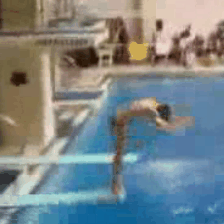

In [ ]:
video_tensor = sample_video["video"]
display_gif(video_tensor)

### Training the model

We'll leverage [`Trainer`](https://huggingface.co/docs/transformers/main_classes/trainer) from  🤗 Transformers for training the model. To instantiate a `Trainer`, we will need to define the training configuration and an evaluation metric. The most important is the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to configure the training. It requires an output folder name, which will be used to save the checkpoints of the model. It also helps sync all the information in the model repository on 🤗 Hub.

Most of the training arguments are pretty self-explanatory, but one that is quite important here is `remove_unused_columns=False`. This one will drop any features not used by the model's call function. By default it's `True` because usually it's ideal to drop unused feature columns, making it easier to unpack inputs into the model's call function. But, in our case, we need the unused features ('video' in particular) in order to create `pixel_values` (which is a mandatory key our model expects in its inputs).

In [ ]:
# !pip install accelerate -U

In [ ]:
from transformers import TrainingArguments, Trainer

model_name = model_ckpt.split("/")[-1]
new_model_name = f"{model_name}-finetuned-ucf101-subset"
num_epochs = 6
batch_size = 1

args = TrainingArguments(
    new_model_name,
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
    max_steps=(train_dataset.num_videos // batch_size) * num_epochs,
)

There's no need to define `max_steps` when instantiating `TrainingArguments`. Since the dataset returned by `pytorchvideo.data.Ucf101()` doesn't implement the `__len__()` method we had to specify `max_steps`.  

Next, we need to define a function for how to compute the metrics from the predictions, which will just use the `metric` we'll load now. The only preprocessing we have to do is to take the argmax of our predicted logits:

In [ ]:
# !pip install evaluate

In [ ]:
import evaluate

metric = evaluate.load("accuracy")

In [ ]:
# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions."""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

**A note on evaluation**:

In the [VideoMAE paper](https://arxiv.org/abs/2203.12602), the authors use the following evaluation strategy. They evaluate the model on several clips from test videos and apply different crops to those clips and report the aggregate score. However, in the interest of simplicity and brevity, we don't consider that in this tutorial.

We also define a `collate_fn`, which will be used to batch examples together.
Each batch consists of 2 keys, namely `pixel_values` and `labels`.

In [ ]:
import torch


def collate_fn(examples):
    """The collation function to be used by `Trainer` to prepare data batches."""
    # permute to (num_frames, num_channels, height, width)
    pixel_values = torch.stack(
        [example["video"].permute(1, 0, 2, 3) for example in examples]
    )
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

Then we just need to pass all of this along with our datasets to the `Trainer`:

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [ ]:
train_results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
0,2.435500,2.379563,0.487923
1,0.877600,1.483801,0.681159
2,0.014600,1.087765,0.739130
3,2.189900,1.347913,0.729469
4,0.001900,0.861529,0.826087
5,0.002100,0.612779,0.855072


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

We can check with the `evaluate` method that our `Trainer` did reload the best model properly (if it was not the last one):

In [ ]:
trainer.evaluate(test_dataset)

{'eval_loss': 1.1652110815048218,
 'eval_accuracy': 0.782608695652174,
 'eval_runtime': 76.546,
 'eval_samples_per_second': 3.005,
 'eval_steps_per_second': 3.005,
 'epoch': 5.17}

In [ ]:
trainer.save_model()
test_results = trainer.evaluate(test_dataset)
trainer.log_metrics("test", test_results)
trainer.save_metrics("test", test_results)
trainer.save_state()

events.out.tfevents.1701714429.ff076e552dd6.1376.3:   0%|          | 0.00/411 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


***** test metrics *****
  epoch                   =       5.17
  eval_accuracy           =     0.7817
  eval_loss               =     1.1702
  eval_runtime            = 0:01:16.92
  eval_samples_per_second =      2.977
  eval_steps_per_second   =      2.977


You can now upload the result of the training to the Hub, just execute this instruction (note that the Trainer will automatically create a model card as well as Tensorboard logs - see the "Training metrics" tab - amazing isn't it?):

In [ ]:
 trainer.push_to_hub()

events.out.tfevents.1701714429.ff076e552dd6.1376.3:   0%|          | 0.00/734 [00:00<?, ?B/s]

'https://huggingface.co/Anukul-02/videomae-base-finetuned-ucf101-subset/tree/main/'

Inferences

In [ ]:
trained_model = VideoMAEForVideoClassification.from_pretrained(new_model_name)

In [ ]:
sample_test_video = next(iter(test_dataset))
investigate_video(sample_test_video)

video torch.Size([3, 16, 224, 224])
video_name v_Diving_g20_c04.avi
video_index 44
clip_index 0
aug_index 0
label 3
Video label: Diving


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


We then prepare the video as a `torch.Tensor` and run inference.

In [ ]:
def run_inference(model, video):
    """Utility to run inference given a model and test video.

    The video is assumed to be preprocessed already.
    """
    # (num_frames, num_channels, height, width)
    perumuted_sample_test_video = video.permute(1, 0, 2, 3)

    inputs = {
        "pixel_values": perumuted_sample_test_video.unsqueeze(0),
        "labels": torch.tensor(
            [sample_test_video["label"]]
        ),  # this can be skipped if you don't have labels available.
    }
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model = model.to(device)

    # forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    return logits

In [ ]:
logits = run_inference(trained_model, sample_test_video["video"])

We can now check if the model got the prediction right.

In [ ]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: Diving


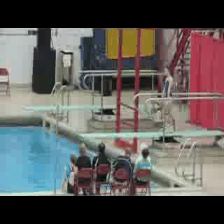

In [ ]:
display_gif(sample_test_video["video"])

**GPT-2 Finetuning for Generating Captions**

In [ ]:
import csv
import os
import argparse
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, get_cosine_with_hard_restarts_schedule_with_warmup
import warnings
warnings.filterwarnings('ignore')

class MyDataset(Dataset):
    def __init__(self, data_file_name):
        super().__init__()

        data_path = os.path.join(data_file_name)

        self.data_list = []
        self.end_of_text_token = "."

        with open(data_path) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=',')

            for row in csv_reader:
                class_name = row[0]
                control_code = row[1]
                caption = row[2]

                # Combine the class, control code, and caption into a single input sequence
                data_str = f"{class_name}: {control_code}: {caption}{self.end_of_text_token}"

                self.data_list.append(data_str)

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, item):
        return self.data_list[item]

def get_data_loader(data_file_name):
	dataset = MyDataset(data_file_name)
	data_loader = DataLoader(dataset, batch_size=1, shuffle=True)
	return data_loader

def train(epochs, data_loader, batch_size, tokenizer, model, device):
	batch_counter = 0
	sum_loss = 0.0

	for epoch in range(epochs):
		print (f'Running {epoch+1} epoch')

		for idx, txt in enumerate(data_loader):
			txt = torch.tensor(tokenizer.encode(txt[0]))
			txt = txt.unsqueeze(0).to(device)
			outputs = model(txt, labels=txt)
			loss, _ = outputs[:2]
			loss.backward()
			sum_loss += loss.data

			if idx%batch_size==0:
				batch_counter += 1
				optimizer.step()
				scheduler.step()
				optimizer.zero_grad()
				model.zero_grad()

			if batch_counter == 10:
				print(f"Total Loss is {sum_loss}") #printed after every 10*batch_size
				batch_counter = 0
				sum_loss = 0.0

	return model




In [ ]:
import sys
args = sys.argv[1:]


def load_models():
	"""
	Summary:
		Loading Pre-trained model
	"""
	print ('Loading/Downloading GPT-2 Model')
	tokenizer = GPT2Tokenizer.from_pretrained('gpt2-medium')
	model = GPT2LMHeadModel.from_pretrained('gpt2-medium')
	return tokenizer, model


In [ ]:
import pandas as pd
import re
from google.colab import files

# Upload the dataset file
uploaded = files.upload()

# Assuming the file name is 'captions_csv.csv', load the dataset
file_name = list(uploaded.keys())[0]  # Extracting the filename from the uploaded files
# Set your parameters here
epoch = 3
warmup = 300
model_name = 'mymodel'
data_file = file_name
batch_size = 32
learning_rate = 3e-5
max_len = 200

Saving social_media_captions.csv to social_media_captions.csv


In [ ]:
TOKENIZER, MODEL = load_models()
LOADER = get_data_loader(data_file)

DEVICE = 'cpu'
if torch.cuda.is_available():
	DEVICE = 'cuda'

model = MODEL.to(DEVICE)
model.train()
optimizer = AdamW(model.parameters(), lr=learning_rate)
scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(optimizer, num_warmup_steps=warmup, num_training_steps=-1)

model = train(epoch, LOADER, batch_size, TOKENIZER, MODEL, DEVICE)
save_model(model, model_name)

Loading/Downloading GPT-2 Model
Running 1 epoch
Running 2 epoch
Running 3 epoch
Total Loss is 1160.704833984375
Saving model to Disk


In [ ]:
import os
import argparse
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import numpy as np

def choose_from_top_k_top_n(probs, k=50, p=0.8):
    # Select the top-k indices and their corresponding probabilities
    ind = np.argpartition(probs, -k)[-k:]
    top_probs = probs[ind]

    # Sort the top-k probabilities and corresponding indices
    sorted_indices = ind[np.argsort(-top_probs)]

    # Select tokens until the cumulative probability exceeds p
    cumulative_prob = 0.0
    selected_tokens = []
    for idx in sorted_indices:
        selected_tokens.append(idx)
        cumulative_prob += probs[idx]
        if cumulative_prob >= p:
            break

    # Normalize the probabilities of the selected tokens
    selected_probs = probs[selected_tokens] / np.sum(probs[selected_tokens])

    # Perform weighted random choice
    token_id = np.random.choice(selected_tokens, 1, p=selected_probs)
    return int(token_id)


In [ ]:
def generate(tokenizer, model, class_name, control_code, max_length=50):
    model.eval()
    prompt = f"{class_name}: {control_code}: "
    generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0).to('cpu')

    with torch.no_grad():
        for _ in range(max_length):
            outputs = model(generated)
            logits = outputs.logits
            softmax_logits = torch.softmax(logits[0, -1], dim=0)
            next_token_id = choose_from_top_k_top_n(softmax_logits.to('cpu').numpy())

            generated = torch.cat([generated, torch.tensor([[next_token_id]]).to('cpu')], dim=1)

            # Check if the next token is the end of a sentence
            if tokenizer.decode([next_token_id]).endswith('.'):
                break

    generated_text = tokenizer.decode(generated[0], skip_special_tokens=True)
    return generated_text.strip()


In [ ]:
def load_models(model_name):
	"""
	Summary:
		Loading the trained model
	"""
	print ('Loading Trained GPT-2 Model')
	tokenizer = GPT2Tokenizer.from_pretrained('gpt2-medium')
	model = GPT2LMHeadModel.from_pretrained('gpt2-medium')
	model_path = model_name
	model.load_state_dict(torch.load(model_path))
	return tokenizer, model

In [ ]:
# List of control codes and their descriptions
control_code_options = {
    1: ("seeking_validation", "Seeking Validation"),   # For captions related to seeking validation
    2: ("conformity_fitting_in", "Conforming to Social Norms"), # For captions about conformity and fitting in
    3: ("empathetic_supportive", "Showing Empathy"),    # For empathetic and supportive content
    4: ("humor_entertainment", "Humor"),        # For humorous and entertaining captions
    5: ("inspirational_aspirational", "Inspirational"), # For inspirational and aspirational messages
    6: ("approachable_relatable", "Relatable")  # For approachable and relatable content
}

# Display the options
print("Please select a control code for generating a social media caption:")
for key, value in control_code_options.items():
    print(f"{key}: {value[0]} - {value[1]}")

# Prompt the user for a choice
user_choice = int(input("Enter your choice (1-6): "))

# Validate the choice
if user_choice in control_code_options:
    selected_control_code = control_code_options[user_choice][1]
    print(f"You have selected: {selected_control_code}")
else:
    print("Invalid choice. Please enter a number between 1 and 6.")


Please select a control code for generating a social media caption:
1: seeking_validation - Seeking Validation
2: conformity_fitting_in - Conforming to Social Norms
3: empathetic_supportive - Showing Empathy
4: humor_entertainment - Humor
5: inspirational_aspirational - Inspirational
6: approachable_relatable - Relatable
Enter your choice (1-6): 5
You have selected: Inspirational


In [ ]:
# Assuming load_models and generate functions are already defined

# Set your parameters directly
model_name = 'mymodel.pt'  # Name of your model file
sentences = 1            # Number of sentences you want to genera
class_name = 'Diving'
control_code = 'Inspirational' #'your_label_here' # Replace with your label

# Load the model
tokenizer, MODEL = load_models(model_name)

caption = generate(tokenizer, model, class_name, control_code, max_length=50)  # Example usage
print(caption)

Loading Trained GPT-2 Model
Diving: Inspirational:  Great fun for the whole family.
